# GPLVM with toroidal latent spaces


### Table of contents

1. [**Synthetic population**](#synthetic)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains code for:
- running GPLVM on synthetic HDC activity with a latent variable on the ring
- running GPLVM or Deep GPs on synthetic place field activity for decoding position
- running conditional GPLVM on place field synthetic data

In [12]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter

import matplotlib.pyplot as plt

import numpy as np


import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.13.0+cu117
Using device: cuda:0


In [2]:
def raster_plot(
    figax, spikes, time_bins, bin_time, units, colors=None, marker="|", markersize=2
):
    """
    Visualize a 2D array representing point events, spikes has shape (timstep, units).

    :param list colors: colors to be included in the colormap
    :param string name: name the colormap
    :returns: figure and axis
    :rtype: tuple
    """
    fig, ax = figax
    if colors is None:
        col = ["k"] * units
    else:
        col = colors
    for i in range(units):
        t = np.nonzero(spikes[i, :])[0] * bin_time
        ax.scatter(t, (i + 1) * np.ones_like(t), c=col[i], s=markersize, marker=marker)

    ax.set_xlim(0, time_bins * bin_time)
    ax.set_ylim(0.1, units + 0.9)
    ax.set_yticks(np.arange(1, units + 1))
    
    
    
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)



def plot_circ_posterior(
    ax,
    times,
    wrap_y,
    y_std,
    col="k",
    linewidth=1.0,
    step=1,
    alpha=0.5,
    line_alpha=1.0,
    l=None,
    l_std=None,
):
    """
    Plot circular variables with (approximate) variational uncertainty.
    """
    if y_std is not None:
        upper = wrap_y + y_std
        lower = wrap_y - y_std

    T = len(wrap_y)
    for i in np.arange(T)[1::step]:
        lines = []
        delta = wrap_y[i] - wrap_y[i - 1]
        if delta > np.pi:
            lines.append(
                ax.plot(
                    [times[i - 1], times[i]],
                    [wrap_y[i - 1], wrap_y[i] - 2 * np.pi],
                    color=col,
                    linewidth=linewidth,
                    label=l,
                    alpha=line_alpha,
                )[0]
            )
            lines.append(
                ax.plot(
                    [times[i - 1], times[i]],
                    [wrap_y[i - 1] + 2 * np.pi, wrap_y[i]],
                    color=col,
                    linewidth=linewidth,
                    label=None,
                    alpha=line_alpha,
                )[0]
            )
        elif delta < -np.pi:
            lines.append(
                ax.plot(
                    [times[i - 1], times[i]],
                    [wrap_y[i - 1], wrap_y[i] + 2 * np.pi],
                    color=col,
                    linewidth=linewidth,
                    label=l,
                    alpha=line_alpha,
                )[0]
            )
            lines.append(
                ax.plot(
                    [times[i - 1], times[i]],
                    [wrap_y[i - 1] - 2 * np.pi, wrap_y[i]],
                    color=col,
                    linewidth=linewidth,
                    label=None,
                    alpha=line_alpha,
                )[0]
            )
        else:
            lines.append(
                ax.plot(
                    [times[i - 1], times[i]],
                    [wrap_y[i - 1], wrap_y[i]],
                    color=col,
                    linewidth=linewidth,
                    label=l,
                    alpha=line_alpha,
                )[0]
            )
            if y_std is not None:  # double locations for uncertainty
                if upper[i] > 2 * np.pi or upper[i - 1] > 2 * np.pi:
                    lines.append(
                        ax.plot(
                            [times[i - 1], times[i]],
                            [wrap_y[i - 1] - 2 * np.pi, wrap_y[i] - 2 * np.pi],
                            color=col,
                            linewidth=linewidth,
                            label=None,
                            alpha=line_alpha,
                        )[0]
                    )
                elif lower[i] < 0 or lower[i - 1] < 0:
                    lines.append(
                        ax.plot(
                            [times[i - 1], times[i]],
                            [wrap_y[i - 1] + 2 * np.pi, wrap_y[i] + 2 * np.pi],
                            color=col,
                            linewidth=linewidth,
                            label=None,
                            alpha=line_alpha,
                        )[0]
                    )

        if y_std is not None:
            for line in lines:
                ax.fill_between(
                    [times[i - 1], times[i]],
                    line.get_ydata() - y_std[i - 1 : i + 1],
                    line.get_ydata() + y_std[i - 1 : i + 1],
                    color=line.get_color(),
                    alpha=alpha,
                    label=l_std,
                )
                l_std = None

        l = None  # no label for each segment after first

        
        
        
# metrics
def metric(x, y, topology="euclid"):
    """
    Returns the geodesic displacement between x and y, (x-y).

    :param torch.tensor x: input x of any shape
    :param torch.tensor y: input y of same shape as x
    :returns: x-y tensor of geodesic distances
    :rtype: torch.tensor
    """
    if topology == "euclid":
        xy = x - y
    elif topology == "torus":
        xy = (x - y) % (2 * np.pi)
        xy[xy > np.pi] -= 2 * np.pi
    elif topology == "circ":
        xy = 2 * (1 - torch.cos(x - y))
    else:
        raise NotImplementedError
    # xy[xy < 0] = -xy[xy < 0] # abs
    return xy



# align latent
def signed_scaled_shift(
    x, x_ref, dev="cpu", topology="torus", iters=1000, lr=1e-2, learn_scale=True
):
    """
    Shift trajectory, with scaling, reflection and translation.

    Shift trajectories to be as close as possible to each other, including
    switches in sign.

    :param np.array theta: circular input array of shape (timesteps,)
    :param np.array theta_ref: reference circular input array of shape (timesteps,)
    :param string dev:
    :param int iters:
    :param float lr:
    :returns:
    :rtype: tuple
    """
    XX = torch.tensor(x, device=dev)
    XR = torch.tensor(x_ref, device=dev)

    lowest_loss = np.inf
    for sign in [1, -1]:  # select sign automatically
        shift = Parameter(torch.zeros(1, device=dev))
        p = [shift]

        if learn_scale:
            scale = Parameter(torch.ones(1, device=dev))
            p += [scale]
        else:
            scale = torch.ones(1, device=dev)

        optimizer = optim.Adam(p, lr=lr)
        losses = []
        for k in range(iters):
            optimizer.zero_grad()
            X_ = XX * sign * scale + shift
            loss = (metric(X_, XR, topology) ** 2).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

        l_ = loss.cpu().item()

        if l_ < lowest_loss:
            lowest_loss = l_
            shift_ = shift.cpu().item()
            scale_ = scale.cpu().item()
            sign_ = sign
            losses_ = losses

    return x * sign_ * scale_ + shift_, shift_, sign_, scale_, losses_


<a id="synthetic"></a>
## Synthetic HDC population

In [19]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [21]:
# seed
rng = np.random.default_rng(123)

# Gaussian von Mises bump head direction model
trials = 1

track_samples = 20000
hd_t = np.empty((trials, track_samples))

hd_t[:, 0] = rng.normal(size=(trials,))*2*np.pi
rn = rng.normal(size=(trials, track_samples-1))
for k in range(track_samples-1):
    hd_t[:, k+1] = hd_t[:, k] + 0.05*rn[:, k]
    
hd_t = hd_t % (2*np.pi)

# tuning
neurons = 50
p_c = np.random.randn(neurons)**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*np.random.randn(neurons))
p_b = 0.2*np.random.randn(neurons)**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

rate = HDC_bumps(hd_t, p_a, p_b, p_c, p_z)  # (tr, neurons, ts)

In [22]:
# IPP spike trains
sample_bin = 0.001
res = torch.poisson(torch.tensor(rate*sample_bin)).numpy()

res_ind = [] # spike times
for tr in range(trials):
    res_ind_ = []
    for n in range(neurons):
        res_ind_.append(utils.neural.binned_to_indices(res[tr, n, :]))
    res_ind.append(res_ind_)

# bin data
bin_size = 20

rc_t = []
rhd_t = []
for tr in range(trials):
    tbin, resamples, rc_t_, (rhd_t_,) = utils.neural.bin_data(bin_size, sample_bin, res_ind[tr], 
                                                            track_samples, (hd_t[tr],), average_behav=False)
    
    rc_t.append(rc_t_)
    rhd_t.append(rhd_t_)
    
rc_t = np.array(rc_t)
rhd_t = np.array(rhd_t)

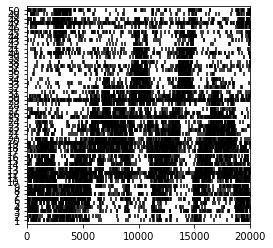

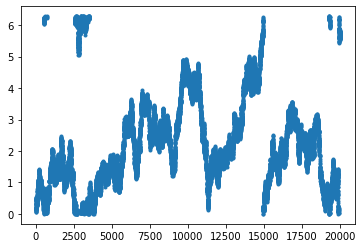

In [23]:
tr = 0

fig, ax = plt.subplots(figsize=(4,4))
raster_plot((fig, ax), res[tr], track_samples, sample_bin*1000, neurons, markersize=10)
#utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.figure()
plt.scatter(np.arange(track_samples), hd_t[tr], marker='.')
plt.show()

### GPLVM with circular latent space

Ring topology $S^1$

In [7]:
out_dims = neurons

# kernel
l = 5.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='torus', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
p = nprb.inputs.priors.tAR1(
    torch.tensor(0.), 
    torch.tensor(4.0), 
    'torus', 
    1, 
)
v = nprb.inputs.variational.IndNormal(
    torch.rand(resamples, 1) * 2*np.pi, 
    torch.ones((resamples, 1)) * 0.1, 
    'torus', 
    1, 
)
input_data = [nprb.inputs.prior_variational_pair(1, p, v)]

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(out_dims, torch.from_numpy(Xu))


# mapping
in_dims = Xu.shape[-1]

gp_lvm = nprb.mappings.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
)


### inputs and likelihood ###
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, resamples, batch_info=500, trials=trials)


#likelihood = mdl.likelihoods.Gaussian(neurons, 'exp', log_var=np.zeros(neurons))
likelihood = nprb.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
#likelihood = mdl.likelihoods.ZI_Poisson(tbin, neurons, 'exp', 0.0*np.zeros(neurons))
likelihood.set_Y(torch.from_numpy(rc_t), batch_info=500) 


glm = nprb.inference.VI_optimized(input_group, gp_lvm, likelihood)
glm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): prior_variational_pair(
      (prior): tAR1(
        (transition): transition_()
      )
      (variational): IndNormal()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [8]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {
    'default': 5*1e-3, 
    'input_group.input_0.variational.finv_std': 5*1e-3,  
}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=2, ll_samples=2, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 1429.


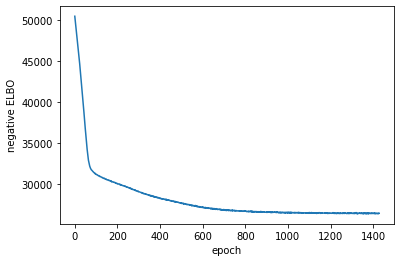

In [9]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

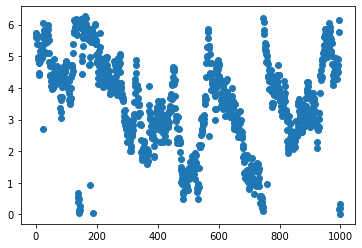

In [10]:
X_loc, X_std = glm.input_group.input_0.variational.eval_moments(0, resamples)
X_loc = X_loc.data.cpu().numpy()
X_std = X_std.data.cpu().numpy()

plt.scatter(np.arange(resamples), X_loc[:] % (2*np.pi))

In [17]:
TRlat_t, shift, sign, scale, _ = signed_scaled_shift(X_loc[:, 0], rhd_t, dev)
TRlat_std = X_std[:, 0]

In [ ]:
steps= 100
show_neurons = [0, 1, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

hd__ = (covariates-shift)/sign

lower, mean, upper = posterior_rate(hd__, show_neurons, 'posterior', n_samp=10)

In [39]:
r_true = HDC_bumps(covariates[0, :], p_a, p_b, p_c, p_z)



for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[neuron], 'r--')
    line, = ax.plot(covariates[0], mean[0, k])
    ax.fill_between(
        covariates[0], lower[0, k],
        upper[0, k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()

# draw tuning curves
samp = 10
#gp_lvm.set_params(jitter=1e-5)
gp_lvm.jitter = 1e-5
tuning = gp_lvm.eval_tuning(covariates, show_neurons, samp)

for k_n in range(len(show_neurons)):
    for n in range(samp):
        plt.plot(tuning[n, k_n, :])

    plt.show()

NameError: name 'shift' is not defined

In [ ]:
# circular posterior
plot_circ_posterior(
    ax, times, wrap_y, y_std, col='k', linewidth=1., step=1, alpha=0.5, line_alpha=1., 
    l=None, l_std=None
)
    
    
    
T = 1000

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim([0, tbin*T])
ax.set_ylim([0, 2*np.pi])
ax.set_yticks([0, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$'])
ax.set_xlabel('time (s)')
ax.set_ylabel('head direction')


ax.errorbar(tbin*np.arange(T), wrap_lat_t[:T], yerr=lat_std[:T], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5 ,label='var. dist.')

X__ = wrap_lat_t[:T]+lat_std[:T]
a = np.where(X__ > 2*np.pi)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]-2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

X__ = wrap_lat_t[:T]-lat_std[:T]
a = np.where(X__ < 0)[0]
ax.errorbar(tbin*np.arange(T)[a], wrap_lat_t[a]+2*np.pi, yerr=lat_std[a], linestyle='', 
            elinewidth=1, color='tab:blue', alpha=0.5)

ax.scatter(tbin*np.arange(T), rhd_t[:T], marker='.', color='r', zorder=2, label='true latents')

ax.legend()
plt.show()
